In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np

In [2]:
assert torch.cuda.is_available(), 'CUDA is not correctly installed!!'
print(torch.tensor([2.0, 3.0, 1.0]).cuda())
property = torch.cuda.get_device_properties(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([2., 3., 1.], device='cuda:0')


In [3]:
print('====== Your GPU info ======')
print('name:\t\t', property.name)
print('capability:\t', 'v{}.{}'.format(property.major, property.minor))
print('memory:\t\t', round(property.total_memory / 1e9), 'Gb')
print('processors:\t', property.multi_processor_count)

====== Your GPU info ======
name:		 Tesla T4
capability:	 v7.5
memory:		 16 Gb
processors:	 40


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# LOAD AND SPLIT DATASET HERE

# Load headers
csv_path = "dataset_v2.csv"

with open(csv_path, 'r', newline='') as csv_fh:
    headers = csv_fh.readline().strip().split(',')
    
    
label_col = "Price"
date_col = "Date(UTC)"
# Load features and labels
x_cols = [i for i in range(len(headers)) if (headers[i] != label_col and headers[i] != date_col)]
l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
prices = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

inputs = np.delete(inputs, -1, axis=0)

# add intercept
new_x = np.zeros((inputs.shape[0], inputs.shape[1] + 1), dtype=inputs.dtype)
new_x[:, 0] = 1
new_x[:, 1:] = inputs

inputs = new_x
print(inputs.shape)

diff = np.diff(prices)
labels = np.where(diff > 0, 1, 0)
print(labels.shape)


# Feature engineering
norm = MinMaxScaler().fit(inputs)
inputs = norm.transform(inputs)

# apply standardization on numerical features
for i in range(inputs.shape[1]):
    
    # fit on training data column
    scale = StandardScaler().fit(inputs[[i]])
    
    # transform the training data column
    inputs[i] = scale.transform(inputs[[i]])


X_train, X_test, y_train,  y_test = train_test_split(
    inputs, labels, test_size=0.1, random_state=42)


(2462, 16)
(2462,)


In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [6]:
epochs = 100000
input_dim = inputs.shape[1] # features 
output_dim = 1 # price
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim).to(device)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# Convert data to tensors, move onto GPU

X_train, X_test = torch.Tensor(X_train).to(device), torch.Tensor(X_test).to(device)
y_train, y_test = torch.Tensor(y_train).to(device), torch.Tensor(y_test).to(device)

In [8]:
# ----------------- TRAIN ------------------
losses = []
losses_test = []
acc = []
acc_test =[]
Iterations = []
iter = 0
step = 10000
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    # Print out benchmarking
    if iter%step==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.cpu().round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.cpu().detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            acc_test.append(accuracy_test)
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).cpu().round().detach().numpy() == y_train.cpu().detach().numpy())
            accuracy = 100 * correct/total
            acc.append(accuracy)
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
        
    iter+=1

Training Epochs:   0%|                    | 182/100000 [00:00<04:56, 337.22it/s]

Iteration: 0. 
Test - Loss: 0.6949512362480164. Accuracy: 48.987854251012145
Train -  Loss: 0.6947212815284729. Accuracy: 49.57110609480813



Training Epochs:  10%|█▋               | 10209/100000 [00:06<00:49, 1811.72it/s]

Iteration: 10000. 
Test - Loss: 0.6911235451698303. Accuracy: 53.84615384615385
Train -  Loss: 0.6904221177101135. Accuracy: 53.04740406320542



Training Epochs:  20%|███▍             | 20314/100000 [00:11<00:44, 1773.00it/s]

Iteration: 20000. 
Test - Loss: 0.6909044981002808. Accuracy: 54.65587044534413
Train -  Loss: 0.6897833347320557. Accuracy: 53.09255079006772



Training Epochs:  30%|█████▏           | 30239/100000 [00:17<00:39, 1762.47it/s]

Iteration: 30000. 
Test - Loss: 0.6907561421394348. Accuracy: 53.84615384615385
Train -  Loss: 0.6894059777259827. Accuracy: 53.04740406320542



Training Epochs:  40%|██████▊          | 40235/100000 [00:23<00:34, 1747.66it/s]

Iteration: 40000. 
Test - Loss: 0.6906603574752808. Accuracy: 54.65587044534413
Train -  Loss: 0.689155638217926. Accuracy: 52.776523702031604



Training Epochs:  50%|████████▌        | 50162/100000 [00:29<00:39, 1256.78it/s]

Iteration: 50000. 
Test - Loss: 0.6905847191810608. Accuracy: 53.84615384615385
Train -  Loss: 0.6889777183532715. Accuracy: 52.91196388261851



Training Epochs:  60%|██████████▏      | 60170/100000 [00:37<00:30, 1300.31it/s]

Iteration: 60000. 
Test - Loss: 0.6905124187469482. Accuracy: 54.25101214574899
Train -  Loss: 0.6888445615768433. Accuracy: 52.64108352144469



Training Epochs:  70%|███████████▉     | 70270/100000 [00:44<00:16, 1773.96it/s]

Iteration: 70000. 
Test - Loss: 0.690437376499176. Accuracy: 54.65587044534413
Train -  Loss: 0.6887406706809998. Accuracy: 52.7313769751693



Training Epochs:  80%|█████████████▋   | 80356/100000 [00:50<00:10, 1804.53it/s]

Iteration: 80000. 
Test - Loss: 0.6903586387634277. Accuracy: 54.25101214574899
Train -  Loss: 0.6886566281318665. Accuracy: 52.957110609480814



Training Epochs:  90%|███████████████▎ | 90303/100000 [00:56<00:05, 1804.14it/s]

Iteration: 90000. 
Test - Loss: 0.6902770400047302. Accuracy: 53.441295546558706
Train -  Loss: 0.6885868310928345. Accuracy: 53.137697516930025



Training Epochs: 100%|████████████████| 100000/100000 [01:02<00:00, 1598.91it/s]


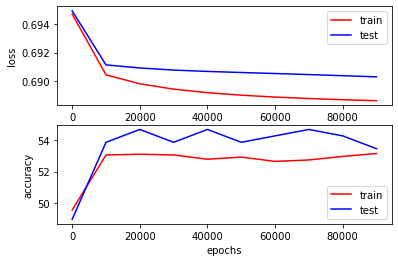

In [9]:
# ------------------- PLOT RESULTS -------------------
fig, (ax1, ax2) = plt.subplots(2, 1)

t = np.arange(epochs, step=step)

ax1.plot(t, losses,'r', label='train')
ax1.plot(t, losses_test, 'b', label='test')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(t, acc,'r', label='train')
ax2.plot(t, acc_test, 'b', label='test')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()
